In [1]:
#imports
#numpy,pandas,scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns

# preprocessing
from sklearn import preprocessing


#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier



#model metrics
from sklearn.metrics import mean_squared_error # regression
from sklearn.metrics import r2_score # regression
from sklearn.metrics import cohen_kappa_score # classification
from sklearn.metrics import accuracy_score # classification
from sklearn.metrics import classification_report # sensitivity

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix # classification
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn import svm, datasets
from sklearn.utils.multiclass import unique_labels
from imblearn.over_sampling import SMOTE


#cross validation
from sklearn.model_selection import train_test_split


In [2]:
# load data
rawData = pd.read_csv('creditSUB.csv', header =0)
rawData = rawData[rawData.columns[1:len(rawData.columns)]]


In [3]:
# select the features from the dataet
rawData = rawData[['LIMIT_BAL', 'MEAN_DELAY', 'EDUCATION', 'AGE',
                              'RATIO_CREDIT_SEP', 'MEAN_BILL', 'MEAN_PAID', 
                              'PAID_SEP','BILL_SEP','DEFAULT']]

# select features for training
indepVar = rawData.drop('DEFAULT', axis=1)

# dependent variable
depVar = rawData['DEFAULT']

0    23364
1     6636
Name: DEFAULT, dtype: int64

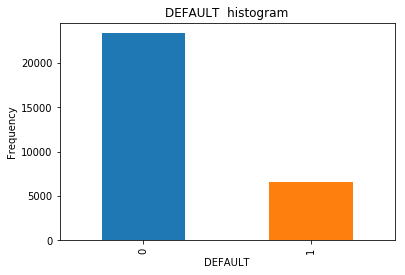

In [4]:
# check the balans of the dataset and rebalance if necessary
pd.value_counts(rawData['DEFAULT']).plot.bar()
plt.title('DEFAULT  histogram')
plt.xlabel('DEFAULT')
plt.ylabel('Frequency')
rawData['DEFAULT'].value_counts()

# Make sure you do it the right way: oversampling on only the training data.

In [5]:
print('Summary of feature sample')
indepVar.head()

Summary of feature sample


,LIMIT_BAL,MEAN_DELAY,EDUCATION,AGE,RATIO_CREDIT_SEP,MEAN_BILL,MEAN_PAID,PAID_SEP,BILL_SEP
0,20000,-0.333333,2,24,0.195650,1284.000000,114.833333,0,3913
1,120000,0.500000,2,26,0.022350,2846.166667,833.333333,0,2682
2,90000,0.000000,2,34,0.324878,16942.166667,1836.333333,1518,29239
3,50000,0.000000,2,37,0.939800,38555.666667,1398.000000,2000,46990
4,50000,-0.333333,2,57,0.172340,18223.166667,9841.500000,2000,8617


In [6]:
np.random.seed(1)
# generate a dataframe that functions as a trainingset
X_train, X_test, y_train, y_test = train_test_split(indepVar, depVar, test_size=0.3)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(21000, 9) (21000,)
(9000, 9) (9000,)


By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable.

In [7]:
# balance the trainingdata
smote = SMOTE(random_state = 4)
X_sm, y_sm = smote.fit_sample(X_train, y_train)

print(X_sm.shape, y_sm.shape)


(32728, 9) (32728,)


In [8]:
# Choose your model
modelRF = RandomForestClassifier()

In [9]:
# Random Forest  Classifier Fitting and Scoring
modelRF.fit(X_sm, y_sm)
print(cross_val_score(modelRF, X_sm, y_sm, cv=5))
modelRF.score(X_sm,y_sm)


/Users/else/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.65933394 0.81927895 0.90574397 0.9025359  0.91045232]


0.9901002199951112

In [10]:
# make predictions with the Random Forest 
predictionsRF = modelRF.predict(X_test)
confusionMatrixRF = confusion_matrix(y_test,predictionsRF)

# print the confusion matrix
confusionMatrixRF = pd.crosstab(y_test, predictionsRF, rownames=['Actual'], colnames=['Predicted'], margins=True)
confusionMatrixRF

Predicted,0,1,All
Actual,,,
0,6265,735,7000
1,1283,717,2000
All,7548,1452,9000


In [14]:
# print accuracy and kappa
accuracyRF = accuracy_score(y_test, predictionsRF)
kappaRF = cohen_kappa_score(y_test, predictionsRF)
print('ACCURACY: %.3f' % accuracyRF)
print('KAPPA: %.3f' % kappaRF)

ACCURACY: 0.776
KAPPA: 0.281


In [12]:
# print accuracy, kappa and other statistics
print(classification_report(y_test, predictionsRF))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      7000
           1       0.49      0.36      0.42      2000

   micro avg       0.78      0.78      0.78      9000
   macro avg       0.66      0.63      0.64      9000
weighted avg       0.76      0.78      0.76      9000



<b>Precision</b> means the percentage of your results which are relevant. It is the ratio of correctly predicted positive observations to the total predicted positive observations. 

<b>Recall</b> refers to the percentage of total relevant results correctly classified by your algorithm.
 
So Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive (True Positive). Applying the same understanding, we know that Recall shall be the model metric we use to select our best model when there is a high cost associated with False Negative.

<b>F1 Score</b> is needed when you want to seek a balance between Precision and Recall. We have previously seen that accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much. Whereas False Negative and False Positive usually has business costs (tangible & intangible) thus F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives).

source: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [13]:
# print feature importance of RF
# list of column names from original data
cols = indepVar.columns
# feature importances from random forest fit rf
rank = modelRF.feature_importances_
# form dictionary of feature ranks and features
features_dict = dict(zip(np.argsort(rank),cols))
# the dictionary key are the importance rank; the values are the feature name
features_dict

{0: 'LIMIT_BAL',
 7: 'MEAN_DELAY',
 3: 'EDUCATION',
 8: 'AGE',
 4: 'RATIO_CREDIT_SEP',
 5: 'MEAN_BILL',
 6: 'MEAN_PAID',
 2: 'PAID_SEP',
 1: 'BILL_SEP'}

In [34]:
# visualize the errrors
# add predicted values to original dataframe

X_test['Predictions'] = predictionsRF

/Users/else/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
